In [2]:
import pandas as pd
import numpy as np

from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = (18.0, 10.0)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from tqdm import tqdm

In [8]:
dataset = pd.read_csv('../data/processed/train_86400000000000.csv', parse_dates=[1])
dataset = dataset.loc[dataset['SiteId'] == 3, :]
dataset.shape

(360, 59)

In [56]:
dataset['IsHoliday'].tail()

1255    False
1256    False
1257    False
1258    False
1259    False
Name: IsHoliday, dtype: bool

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c21be4208>,
      dtype=object)

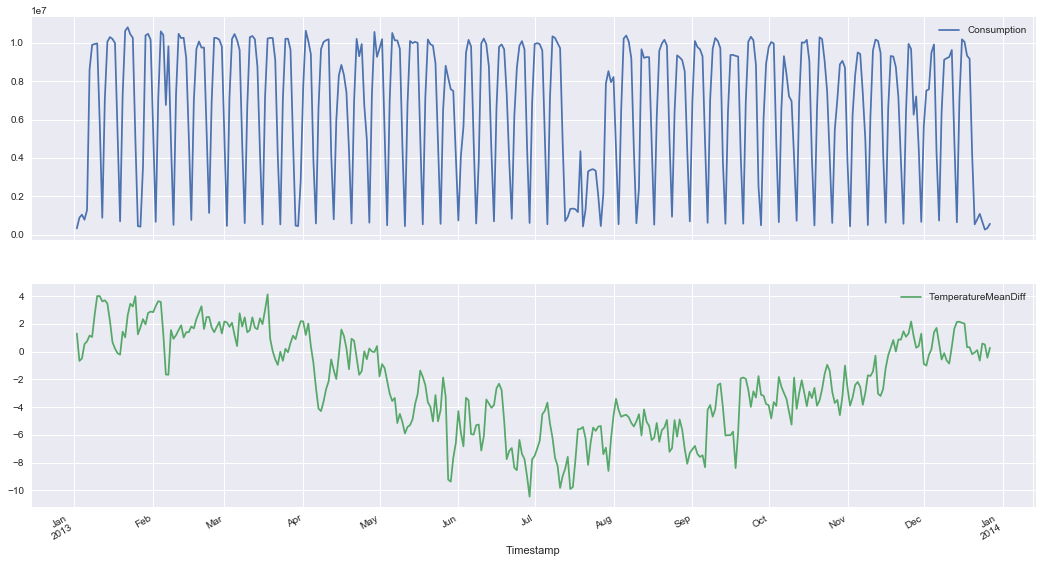

In [55]:
dataset.set_index('Timestamp')[['Consumption', 'TemperatureMeanDiff', 'IsHoliday']].plot(subplots=True)

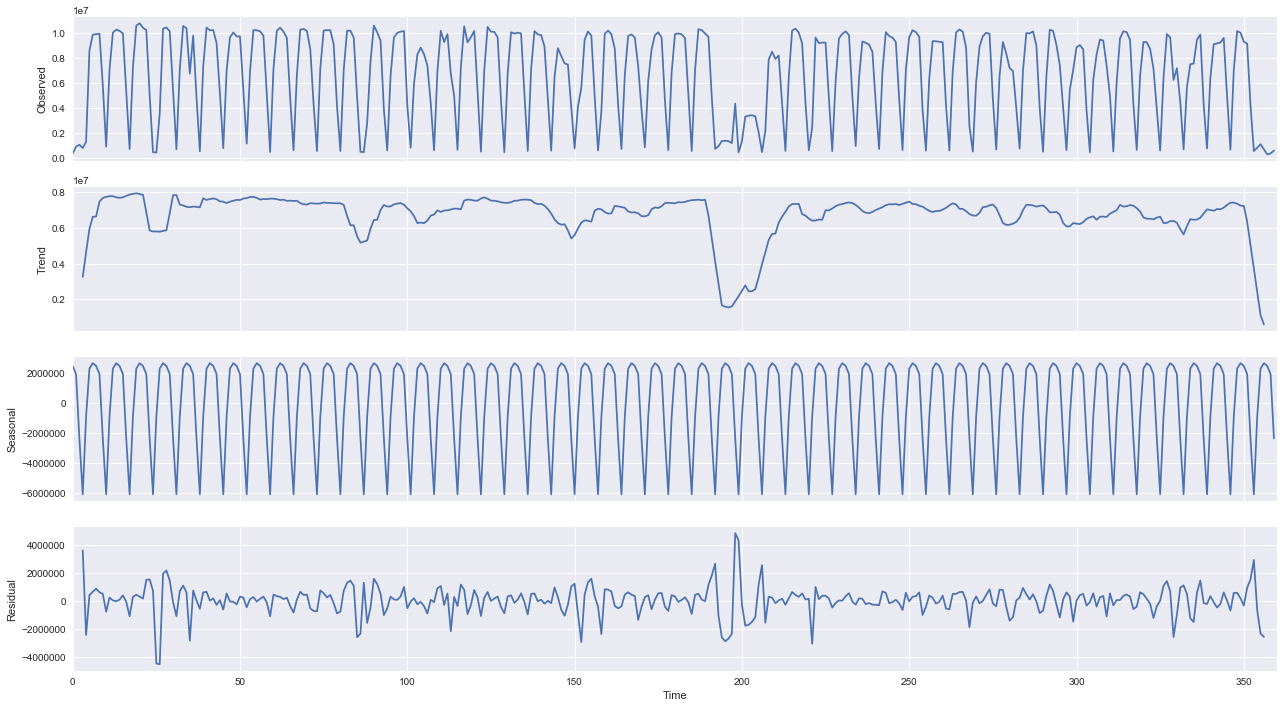

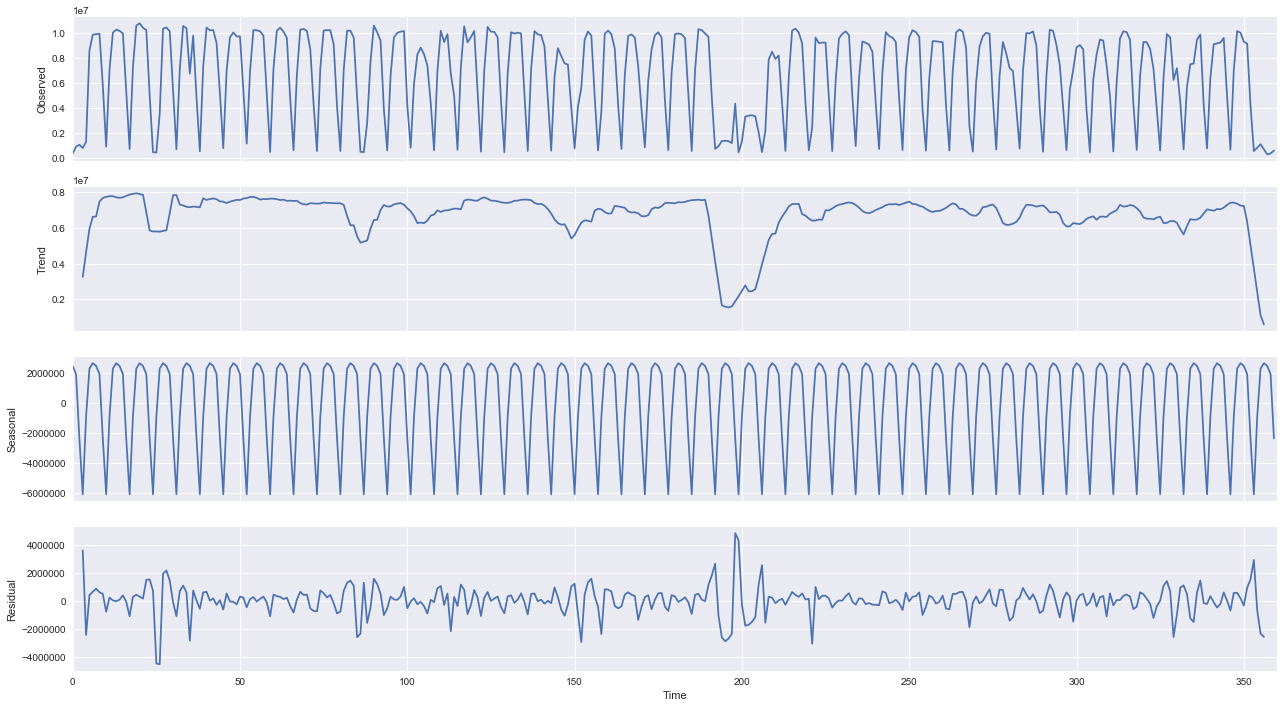

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose

res = seasonal_decompose(dataset['Consumption'].values, freq=7)

res.plot()

In [28]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        
    print(dfoutput)

/Users/sreejithkrishnanr/Tools/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  """
/Users/sreejithkrishnanr/Tools/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  


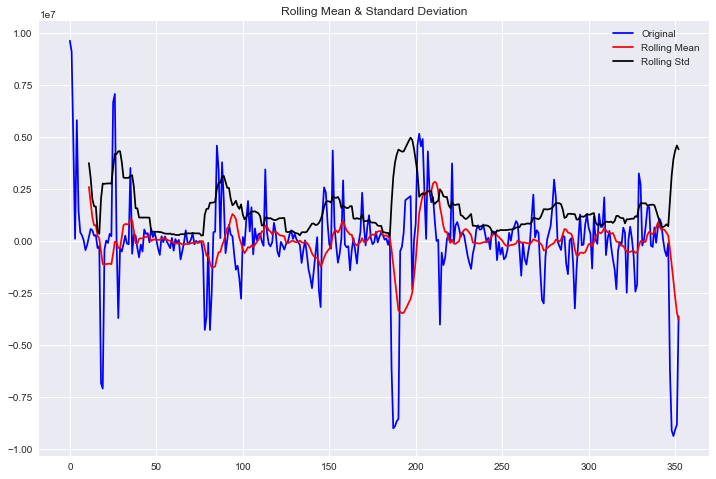

Results of Dickey-Fuller Test:
Test Statistic                -5.751846e+00
p-value                        5.941482e-07
#Lags Used                     1.700000e+01
Number of Observations Used    3.350000e+02
Critical Value (1%)           -3.450022e+00
Critical Value (5%)           -2.870207e+00
Critical Value (10%)          -2.571387e+00
dtype: float64


In [34]:
test_stationarity((dataset['Consumption'] - dataset['Consumption'].shift(7)).dropna().values)

In [70]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

y_train = dataset['Consumption'].values[:-59]
y_test = dataset['Consumption'].values[-59:]
model = SARIMAX(y_train, order=(0, 1, 0), seasonal_order=(1, 1, 1, 7))
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  301
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 7)   Log Likelihood               -4570.048
Date:                           Sun, 18 Mar 2018   AIC                           9146.095
Time:                                   18:37:51   BIC                           9157.217
Sample:                                        0   HQIC                          9150.546
                                           - 301                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7        0.2118      0.048      4.423      0.000       0.118       0.306
ma.S.L7       -0.9963      0.047    -21.204      0.000      -1.088      -0.904
sigma2      1.989e+12   2.39e-14    8.3e+25      0.000    1.99e+12    1.99e+12
===================================================================================
Ljung-Box (Q):                       57.79   Jarque-Bera (JB):               364.78
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               0.34   Skew:                             0.80
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.95e+40. Standard errors may be unstable.
"""

In [41]:
print(y_train.shape, y_test.shape)

(301,) (59,)


In [71]:
y_pred = results.predict(start=301, end=301+59-1, dynamic=True)
y_pred.shape

(59,)

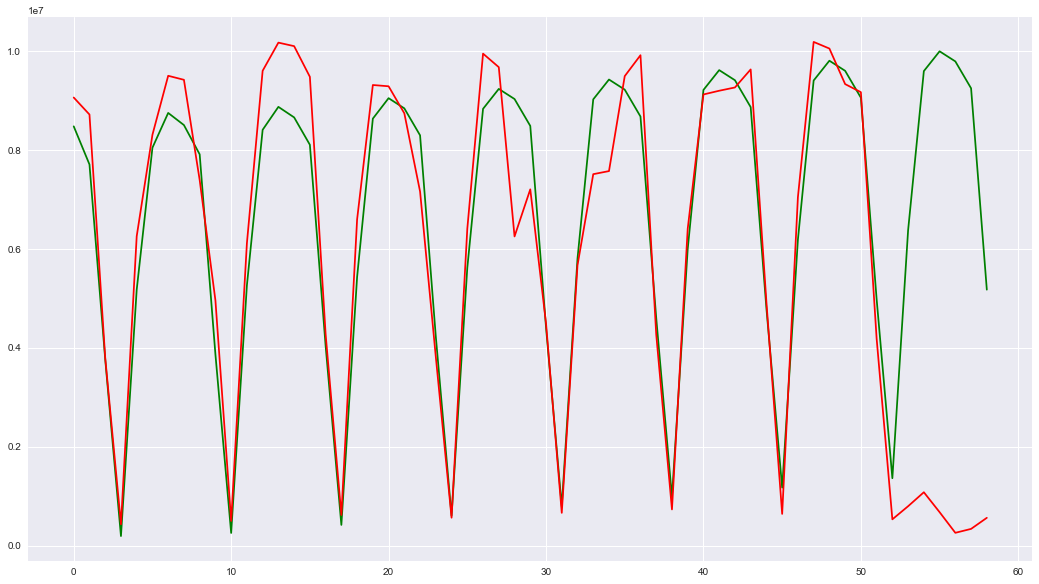

In [72]:
plt.plot(range(y_pred.shape[0]), y_pred, color='green')
plt.plot(range(y_pred.shape[0]), y_test, color='red')